In [164]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb

In [118]:
DATA_DIR = 'data'
TICKERS = ['BTC','ETH','LTC','XRP','DOGE']

In [119]:
data_raw = {}
for ticker in TICKERS:
    data_raw[ticker] = pd.read_csv(f'{DATA_DIR}/{ticker}.csv', sep = ';', parse_dates=['date'])

data_raw = pd.concat(data_raw).droplevel(level = 1)


In [120]:
data_raw.columns

Index(['date', 'sigma', 'ret', 'retSD', 'VolumeExch', 'AdrActCnt', 'DiffMean',
       'FeeMeanUSD', 'HashRate', 'IssContPctAnn', 'IssTotUSD', 'NVTAdj',
       'PriceBTC', 'PriceUSD', 'SplyCur', 'TxTfrCnt', 'TxTfrValAdjNtv',
       'TxTfrValAdjUSD', 'GoogleTrends', 'GoogleTrendsCrypto', 'ExchangeRatio',
       'USDEUR', 'VIX', 'Gold', 'Wiki', 'SP', 'FeeMeanNtv'],
      dtype='object')

In [121]:
data = data_raw.copy(deep = True)

# cleaning ',' from falues and converting to float
for c in data_raw.columns[1:]: 
    try: 
        data.loc[(data[c] == "#DIV/0!"),c] = np.nan
        data.loc[:,c] = pd.to_numeric(data_raw[c].str.replace(',','.'), errors = 'coerce')
    except:
        print(c)

AdrActCnt
TxTfrCnt
Wiki


In [122]:
data = data.loc[~data['retSD'].isnull(),:]
data = data.reset_index().rename(columns = {'index': 'ticker'})
data['ticker'] = data['ticker'].astype('category')

In [123]:
# adding ticker to features 
features = ['VolumeExch','AdrActCnt','DiffMean','FeeMeanUSD','HashRate','IssContPctAnn','NVTAdj','SP','USDEUR'] + ['ticker']
# not really "predicting" as this is the same period
labels = ['retSD']

In [125]:
data['date'].min(), data['date'].max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2022-01-31 00:00:00'))

In [237]:
# should be done better (k-fold ts validation within each ticker)
date_split =  '2020-01-01'
data_train = data.query("date < @date_split")
data_test = data.query("date >=  @date_split")

In [243]:

# detault hyperparameters, good for more standard tabular datasets, for financial data need some love
hyperparams = {
    'boosting_type':'gbdt',
    'num_leaves': 31,
    'n_estimators': 100, #
    'learning_rate': 0.01,
    'reg_alpha': 1e-1,
    'reg_lambda': 1e-1,

    }
model = lgb.LGBMRegressor(**hyperparams)

model.fit(X = data_train[features],y = data_train[labels],  categorical_feature= ['ticker'])

/home/crozier/.local/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMRegressor(learning_rate=0.01, reg_alpha=0.1, reg_lambda=0.1)

In [244]:
data_train['prediction_is'] = model.predict(data_train[features])
data_test['prediction'] = model.predict(data_test[features])

<ipython-input-244-c81f922290fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['prediction_is'] = model.predict(data_train[features])
<ipython-input-244-c81f922290fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['prediction'] = model.predict(data_test[features])


BTC
R2: 0.10886721770366314
MSE: 1.2140627142700973
ETH
R2: 0.0800350364520167
MSE: 1.1787373555049754
LTC
R2: 0.057426901277658704
MSE: 1.1672273292212472
XRP
R2: 0.04517033903811907
MSE: 1.294126728207839
DOGE
R2: 0.06079743160180884
MSE: 0.855728920078549


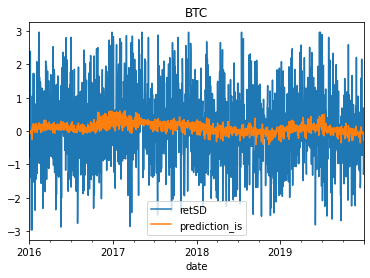

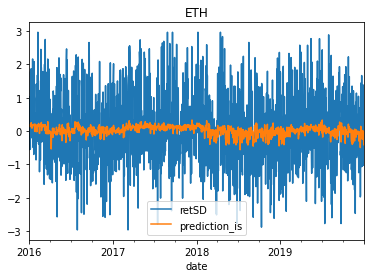

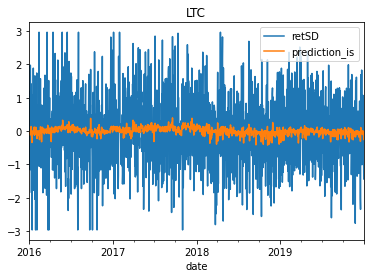

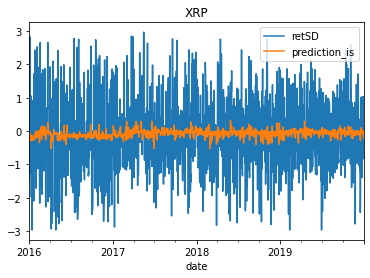

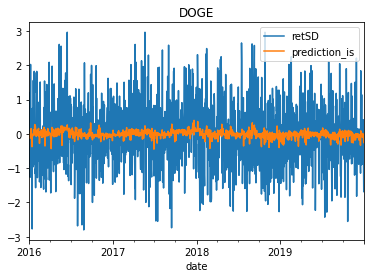

In [245]:
for ticker in data_train['ticker'].unique():
    ticker_data = data_train.query("ticker == @ticker").set_index('date')
    ticker_data[['retSD','prediction_is']].plot(title = ticker)
    print(ticker)
    print('R2: ' + str(r2_score(ticker_data['retSD'],ticker_data['prediction_is'])))
    print('MSE: ' + str(mean_squared_error(ticker_data['retSD'],ticker_data['prediction_is'])))

BTC
R2: -0.02819683853888777
MSE: 1.157013079394952
ETH
R2: -0.07604330430049311
MSE: 1.2755017095766061
LTC
R2: -0.028479611660751303
MSE: 1.0235564889305482
XRP
R2: -0.025531714378857373
MSE: 0.9828604329252587
DOGE
R2: -0.013422513751807807
MSE: 0.9002430673151967


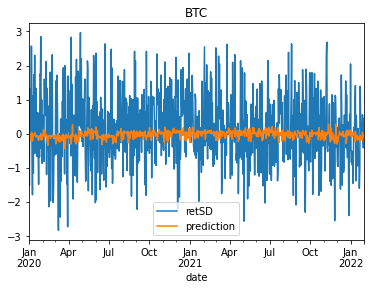

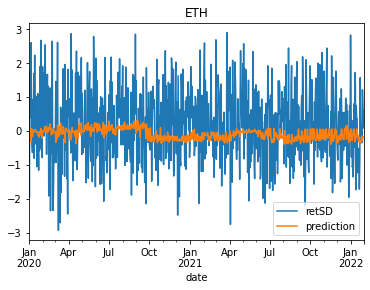

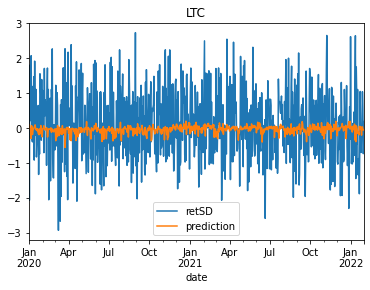

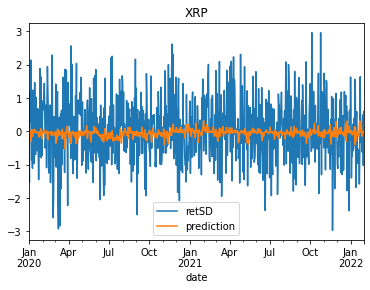

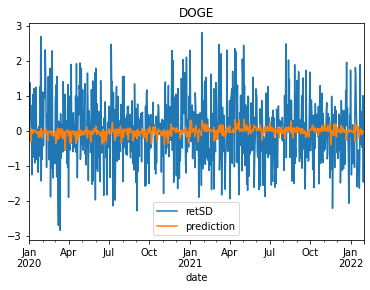

In [246]:
# with default hyperparams tends to overfit
for ticker in data_test['ticker'].unique():
    ticker_data = data_test.query("ticker == @ticker").set_index('date')
    ticker_data[['retSD','prediction']].plot(title = ticker)
    print(ticker)
    print('R2: ' + str(r2_score(ticker_data['retSD'],ticker_data['prediction'])))
    print('MSE: ' + str(mean_squared_error(ticker_data['retSD'],ticker_data['prediction'])))